In [2]:
# !pip install geopandas folium matplotlib seaborn scipy
# !pip install esda
# !pip install splot
# # for google colab, had to reinstall some pacakges.

In [49]:
import pandas as pd
import numpy as np
from scipy import stats
import datetime as dt
import matplotlib
import matplotlib.pyplot as plt
import os
import io
import geopandas as gpd
import seaborn as sns

# suppress warning
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
file_path1 = '/content/drive/My Drive/X999/bbl_evictions_merged.csv'

In [7]:
file_path2 = '/content/drive/My Drive/X999/svi_cleaned.csv'

In [10]:
bbl_evictions_df = pd.read_csv(file_path1)

In [11]:
svi_df = pd.read_csv(file_path2)

In [12]:
svi_simplified = svi_df[['FIPS', 'E_TOTPOP',
                        'RPL_THEME1', 'RPL_THEME2', 'RPL_THEME3', 'RPL_THEME4', 'RPL_THEMES',
                        'EP_POV150', 'EP_UNEMP', 'EP_NOHSDP', 'EP_UNINSUR',
                        'EP_AGE65', 'EP_AGE17', 'EP_DISABL', 'EP_LIMENG',
                        'EP_NOVEH', 'EP_CROWD', 'EP_HBURD',
                        'EP_AFAM', 'EP_HISP', 'EP_ASIAN', 'EP_AIAN', 'EP_NHPI',
                        'EP_TWOMORE', 'EP_OTHERRACE', 'EP_MINRTY']]

In [18]:
svi_df.shape, svi_simplified.shape

((204, 156), (204, 27))

In [13]:
svi_simplified['EP_WHITE'] = 100 - svi_simplified['EP_MINRTY']

In [14]:
bbl_evictions_df.eviction_postcode.dtype, svi_simplified.FIPS.dtype

(dtype('int64'), dtype('int64'))

In [15]:
bbl_evictions_df['eviction_postcode'] = bbl_evictions_df['eviction_postcode'].astype(str)
svi_simplified['FIPS'] = svi_simplified['FIPS'].astype(str)

In [16]:
merged_df = pd.merge(bbl_evictions_df,
                    svi_simplified,
                    left_on='eviction_postcode',
                    right_on='FIPS',
                    how='left')

In [17]:
missing_svi = merged_df['RPL_THEMES'].isna().sum()
print(missing_svi/len(merged_df)*100,"% missing rows")

2.22456197186901 % missing rows


In [19]:
if missing_svi > 0:
    missing_postcodes = merged_df[merged_df['RPL_THEMES'].isna()]['eviction_postcode'].unique()
    print(f"missing SVI data in these zipcodes: {missing_postcodes}")

missing SVI data in these zipcodes: ['11694' '11691' '11692' '11693' '11040' '10101' '11001' '11384' '11439'
 '11242' '10424' '11137' '11443' '11266' '11272' '11698' '10000' '11442'
 '10433' '11382' '10041' '11202' '11467' '10360' '10260']


In [20]:
missing_postcodes = merged_df[merged_df['RPL_THEMES'].isna()]['eviction_postcode'].unique()

In [21]:
merged_df_clean = merged_df[~merged_df['eviction_postcode'].isin(missing_postcodes)]
merged_df.shape, merged_df_clean.shape, len(merged_df) - len(merged_df_clean)

((74082, 67), (72434, 67), 1648)

In [35]:
# merged_df_clean.columns

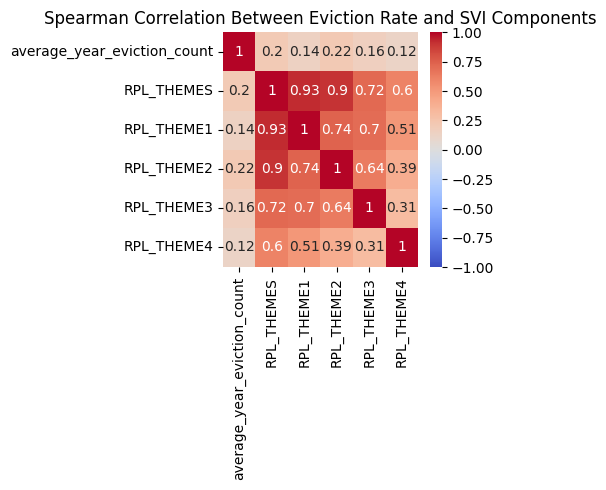

In [44]:
key_vars = ['average_year_eviction_count', 'RPL_THEMES', 'RPL_THEME1', 'RPL_THEME2', 'RPL_THEME3', 'RPL_THEME4']
correlation_heatmap = merged_df_clean[key_vars].corr(method='spearman')

plt.figure(figsize=(5, 5))
sns.heatmap(correlation_heatmap, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Spearman Correlation Between Eviction Rate and SVI Components')
plt.tight_layout()
plt.savefig('eviction_svi_correlation.png')

In [52]:
key_vars = ['average_year_eviction_count', 'RPL_THEMES', 'RPL_THEME1', 'RPL_THEME2', 'RPL_THEME3', 'RPL_THEME4']
correlation_results = {}

for var in key_vars[1:]:
    correlation, p_value = stats.spearmanr(merged_df_clean['average_year_eviction_count'], merged_df_clean[var])
    correlation_results[var] = {'correlation': correlation, 'p_value': p_value}

for var, results in correlation_results.items():
    significance = "significant" if results['p_value'] < 0.05 else "not significant"
    print(f"correlation between eviction rate and {var}: r = {results['correlation']:.3f}, p = {results['p_value']:.4f} ({significance})")

correlation between eviction rate and RPL_THEMES: r = 0.203, p = 0.0000 (significant)
correlation between eviction rate and RPL_THEME1: r = 0.145, p = 0.0000 (significant)
correlation between eviction rate and RPL_THEME2: r = 0.218, p = 0.0000 (significant)
correlation between eviction rate and RPL_THEME3: r = 0.158, p = 0.0000 (significant)
correlation between eviction rate and RPL_THEME4: r = 0.121, p = 0.0000 (significant)


The relatively weak correlations between eviction rates and SVI components suggest that evictions in NYC are not simply driven by social vulnerability as measured by the SVI. Other factors not captured in the SVI (such as local housing policies, landlord practices, or rental market conditions) likely play important roles.

The household composition/disability theme having the strongest correlation (but still weak) might indicate that household structure and disability status may be slightly more relevant to eviction risk than other vulnerability factors.

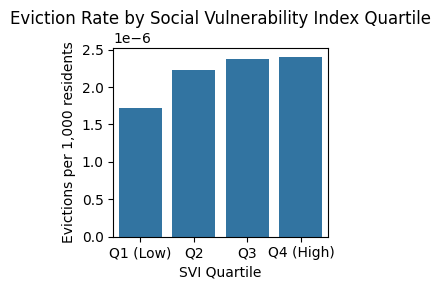

In [43]:
merged_df_clean['svi_quartile'] = pd.qcut(merged_df_clean['RPL_THEMES'], 4, labels=['Q1 (Low)', 'Q2', 'Q3', 'Q4 (High)'])
quartile_analysis = merged_df_clean.groupby('svi_quartile').agg({
    'average_year_eviction_count': 'mean',
    'eviction_count': 'sum',
    'E_TOTPOP': 'sum'
}).reset_index()
quartile_analysis['total_eviction_rate'] = quartile_analysis['average_year_eviction_count'] / quartile_analysis['E_TOTPOP'] * 1000
plt.figure(figsize=(3, 3))
sns.barplot(x='svi_quartile', y='total_eviction_rate', data=quartile_analysis)
plt.title('Eviction Rate by Social Vulnerability Index Quartile')
plt.ylabel('Evictions per 1,000 residents')
plt.xlabel('SVI Quartile')
plt.tight_layout()
plt.savefig('eviction_by_svi_quartile.png')

Though with fairly weak correlation, we do see more people with higher svi score experienced more evictions than others.

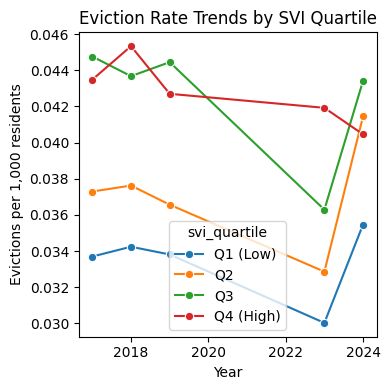

In [36]:
time_analysis = merged_df_clean.groupby(['year', 'svi_quartile']).agg({
    'average_year_eviction_count': 'sum',
    'E_TOTPOP': 'sum'
}).reset_index()
time_analysis['yearly_eviction_rate'] = time_analysis['average_year_eviction_count'] / time_analysis['E_TOTPOP'] * 1000

plt.figure(figsize=(4, 4))
sns.lineplot(x='year', y='yearly_eviction_rate', hue='svi_quartile', data=time_analysis, marker='o')
plt.title('Eviction Rate Trends by SVI Quartile')
plt.ylabel('Evictions per 1,000 residents')
plt.xlabel('Year')
plt.tight_layout()
plt.savefig('eviction_trends_svi.png')

though svi is not a strong preditor for evictions, it does show that over time, people with higher svi are more likely to experience evictions.